## Finding Adjacent Repeats


Given a sequence of numbers, find and mark adjacent repeats. Repeats can be of length 3-10.

```
input  = 0 3 5 9 3 3 5 2 5
output = 0 0 0 0 1 1 0 0 0

input  = 1 2 2 2 2 2 3 1 5
output = 0 1 1 1 1 1 0 0 0

```

In [62]:
import torch
import numpy as np

from radam import RAdam
from torch.utils.data import DataLoader, Dataset
from transformers import BertConfig, BertModel

from utils import train, get_output_for_example, plot_losses

In [63]:
def generate_data(num_examples: int, seq_len: int, vocab_size: int):
    inputs = np.random.randint(0, vocab_size, size=(num_examples, seq_len))
    outputs = np.zeros_like(inputs)
    
    for i in range(len(inputs)):
        
        # choose number of duplicates to introduce
        num_duplicates = np.random.randint(3, 5)
        
        # choose random location to introduce our duplicates
        location = np.random.randint(0, len(inputs[i]) - num_duplicates)
        
        # Choose what number we'd like to repeat
        number_to_repeat = np.random.randint(0, vocab_size)
        
        inputs[i][location:location + num_duplicates] = number_to_repeat
        
        # Mark location where duplicates exist
        outputs[i][location:location + num_duplicates] = 1
        

    return inputs, outputs

In [64]:
# We're lazy so we're going to just use a large vocabulary 
# instead of manually removing accidental duplicates
generate_data(num_examples=1, seq_len=10, vocab_size=1000)

(array([[467, 467, 467, 467, 827,  97, 318, 535, 393, 695]]),
 array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]))

In [65]:
class ToyDataset(Dataset):
   
    def __init__(self, num_examples, sequence_length, vocab_size):
        self.items, self.labels = generate_data(num_examples, sequence_length, vocab_size)
        
    def __getitem__(self, idx):
        
        x = torch.Tensor(self.items[idx]).long()
        y = torch.Tensor(self.labels[idx]).long()
        return x.cuda(), y.cuda()
    
    def __len__(self):
        return len(self.items)

In [66]:
class ToyModel(torch.nn.Module):
    """
    Wrapper around a BERT model that predicts a single binary output for each input token
    """
    
    def __init__(self, vocab_size):
        super().__init__()
        
        # Untrained BERT Model
        config = BertConfig(vocab_size_or_config_json_file=vocab_size)
        self.bert_model = BertModel(config)
        self.linear = torch.nn.Linear(in_features=768, out_features=2)
        
    def forward(self, x):    
        out, _ = self.bert_model(x)
        out = self.linear(out)
        return out    

In [67]:
TRN_EXAMPLES = 10000
VAL_EXAMPLES = 1000
SEQUENCE_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [68]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [69]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [70]:
train_loss, valid_loss, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15)

Epoch:	 0 	Step:	 0 	Loss:	 0.7466895580291748
Epoch:	 0 	Step:	 100 	Loss:	 0.5742200613021851
Epoch:	 0 	Step:	 200 	Loss:	 0.5781816840171814
Epoch:	 0 	Step:	 300 	Loss:	 0.5500578284263611
Epoch:	 0 			Valid Accuracy	 0.6586914
Epoch:	 1 	Step:	 0 	Loss:	 0.5566102266311646
Epoch:	 1 	Step:	 100 	Loss:	 0.5791091322898865
Epoch:	 1 	Step:	 200 	Loss:	 0.5728290677070618
Epoch:	 1 	Step:	 300 	Loss:	 0.5278732776641846
Epoch:	 1 			Valid Accuracy	 0.69248044
Epoch:	 2 	Step:	 0 	Loss:	 0.5383020043373108
Epoch:	 2 	Step:	 100 	Loss:	 0.5000514984130859
Epoch:	 2 	Step:	 200 	Loss:	 0.3650267720222473
Epoch:	 2 	Step:	 300 	Loss:	 0.32407498359680176
Epoch:	 2 			Valid Accuracy	 0.8146484
Epoch:	 3 	Step:	 0 	Loss:	 0.3183962106704712
Epoch:	 3 	Step:	 100 	Loss:	 0.35692742466926575
Epoch:	 3 	Step:	 200 	Loss:	 0.22187435626983643
Epoch:	 3 	Step:	 300 	Loss:	 0.09352169930934906
Epoch:	 3 			Valid Accuracy	 0.90527344
Epoch:	 4 	Step:	 0 	Loss:	 0.16367337107658386
Epoch:	 4 	Ste

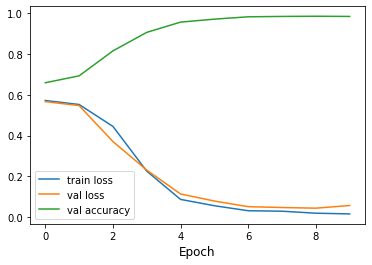

In [71]:
plot_losses(train_loss, valid_loss, valid_acc)

In [77]:
# Check if we're learned how to perform on items in the train dataset
x, y = valid_ds[10]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([188, 311, 311, 311, 311, 311, 794,  34, 627, 848], device='cuda:0')
y:	 tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
y_hat:	 tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
